In [1]:
import sys
print(sys.executable)

/home/ubuntu/anaconda3/envs/shun/bin/python


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.text import *

In [4]:
torch.cuda.set_device(0)

In [5]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/imdb_sample/texts.csv')]

In [6]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [7]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [8]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [9]:
data_lm.save()

In [10]:
data = TextDataBunch.load(path)

In [11]:
data = TextClasDataBunch.load(path)
data.show_batch()

text,target
"xxbos xxfld 1 xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxfld 1 xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come",positive
"xxbos xxfld 1 xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n\n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxfld 1 xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n\n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxfld 1 xxmaj many xxunk that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj",positive


In [12]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.']

In [13]:
data.train_ds[0][0]

Text xxbos xxfld 1 i was required to watch the movie for my work , so i did n't pay for it ( on the contrary , i got paid ) , but i still found the movie to suck far more than average . xxmaj the jokes were lame , the two lead actresses ... well , to use the " xxmaj first wives club " xxunk of women 's ages in xxmaj hollywood , they are no longer in their " hot chick " age but more in their " xxunk xxunk " age . xxmaj what xxunk me most about the movie was the main plot line , which pretty much completely xxunk " xxmaj xxunk & xxmaj xxunk xxmaj do xxmaj america " ( in which the boys are all xxunk up about some dude offering them money to " do his wife " , not realizing they 're expected to xxunk her ) . xxmaj all in all , a bland piece of crap .

In [14]:
data.train_ds[0][0].data[:10]

array([   2,    3,   45,   18,   25, 2370,   14,  127,    8,   26])

In [15]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

In [16]:
bs=48

In [17]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/test'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/README')]

In [18]:
(path/'train').ls()

[PosixPath('/home/ubuntu/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train/pos'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train/unsup'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train/neg')]

In [19]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm')

In [20]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [21]:
data_lm.show_batch()

idx,text
0,"xxbos "" xxmaj sky xxmaj captain and the xxmaj world of xxmaj tomorrow "" ( an amazingly xxunk title ) is simply a bad movie ; it has no heart , no deep ideas , nothing very special about it . xxmaj yes , the xxup cgi backgrounds look interesting , but the result is that the whole thing is shot in an annoying soft focus . xxmaj additionally ,"
1,"like horror movies but any movie that has xxmaj jeffrey xxmaj combs , xxmaj seth xxmaj green and xxmaj alice xxmaj cooper is my kind of movie . xxmaj definitely rent this is if you are a fan of xxmaj jeffrey xxmaj combs . xxbos i absolutely xxup loved this movie ! xxmaj it was xxup so good ! xxmaj this movie is told by the parrot , xxmaj paulie"
2,"situation an ominous atmosphere which makes the viewer feel uncomfortable . xxmaj is there anything more trite than a dinner with one 's boss ? xxmaj but when xxmaj rampling asks xxmaj dussollier the following question : "" xxmaj was it one of your b xxrep 6 * ? "" , a feeling of unpleasantness invades the viewer and stays inside him or her until the middle of the film"
3,movies themselves . xxmaj adrian xxmaj paul is a really talented actor & though i feel their acting was dead on ... the script for this movie was xxup horrible . \n\n xxmaj it was as awful as xxmaj highlander xxup ii ... it just left me feeling like someone ... wanted to revive the movie to make a few dollars . xxmaj it was as if they threw this
4,"but his character 's stamina is remarkable ; he flies in from xxmaj australia , apparently goes straight to the xxmaj commissioner 's house ( rather unwisely seeking to arrest him during a black - tie reception ) , saves him from assassination ( getting into a fight in the process ) , goes to a casino with one girl , leaves with another and takes her to bed ."


In [22]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


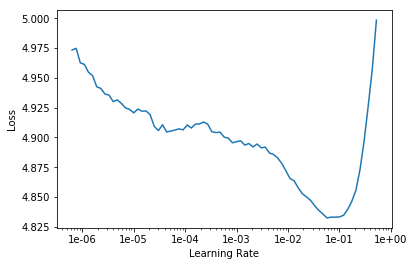

In [24]:
learn.recorder.plot(skip_end=15)

In [25]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.242076,4.066875,0.292398


In [26]:
learn.save('fit_head')

In [27]:
learn.load('fit_head');

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(20, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.983937,3.917430,0.306455
2,3.903845,3.847914,0.314845
3,3.860485,3.806052,0.321114
4,3.812126,3.774317,0.325151
5,3.796584,3.748883,0.327846
6,3.720733,3.723171,0.330642
7,3.718934,3.708667,0.332267
8,3.656394,3.693697,0.334087
9,3.643703,3.684552,0.335070
10,3.632314,3.675832,0.335816


In [30]:
learn.save('fine_tuned')

In [31]:
learn.load('fine_tuned');

In [32]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [33]:
print("\n".join(learn.predict(TEXT, N_WORDS) for _ in range(N_SENTENCES)))

i liked this movie because i liked maybe a little . xxmaj but once i got into it it was worth the wait ! xxbos xxup ok , so i have to say this was a pretty good movie in my opinion . xxmaj but
i liked this movie because it does contact those who know the anything about experience and iron and automobiles . it is a movie worth a views with those that choose not to take course if you are a minority of pure gay men .


In [34]:
learn.save_encoder('fine_tuned_enc')

In [35]:
path = untar_data(URLs.IMDB)

In [36]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('tmp_clas')

In [37]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)

In [38]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxup myra xxup breckinridge is one of those rare films that established its place in film history immediately . xxmaj praise for the film was absolutely nonexistent , even from the people involved in making it . xxmaj this film was loathed from day one . xxmaj while every now and then one will come across some maverick who will praise the film on philosophical grounds ( aggressive feminism",neg
"xxbos xxmaj god ! xxmaj zorro has been the the subject of about as many movies as xxmaj tarzan , and probably had about as many actors in the title role . \n\n xxmaj this xxmaj serial is one of my own personal favourites , and as previously stated , it is one of the xxmaj top 5 xxmaj sound xxmaj serials . xxmaj oddly enough , this is one",pos
"xxbos xxmaj obviously , i did n't care for xxmaj things to xxmaj come ( aka "" xxmaj the xxmaj shape of xxmaj things to xxmaj come "" ) as much as most viewers . xxmaj that means that there is a good chance that you 'll enjoy it more than i did . xxmaj at any rate , you might find it useful to hear the film described from",neg
"xxbos i remember watching this late at night on black and white xxup tv , long before a live - action version was so much as a twinkle in xxmaj peter xxmaj jackson 's eye ... and being very impressed . xxmaj finally getting my hands this week on a xxup vhs copy that was being thrown away ( and is n't that just par for the course .. ?",pos


In [39]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [40]:
gc.collect();

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


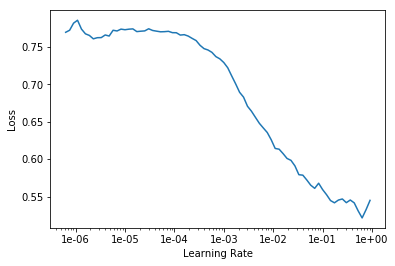

In [42]:
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.320074,0.196942,0.924800


In [44]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.320022,0.189243,0.929400


In [45]:
learn.save('first')

In [46]:
learn.load('first');

In [47]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.265846,0.165163,0.939440


In [48]:
learn.save('second')

In [49]:
learn.load('second');

In [50]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.252633,0.153107,0.944400


In [51]:
learn.save('third')

In [52]:
learn.load('third');

In [53]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.236234,0.150851,0.946320
2,0.204029,0.154092,0.945400


In [54]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([7.9970e-06, 9.9999e-01]))